In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir "/content/images"
!mkdir "/content/images/test"
!unrar x "/content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/images/test/test.rar" "/content/images/test"
!cp "/content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/images/test/annotations.json" "/content/images/test"
!mkdir "/content/images/train"
!cp "/content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/images/train/annotations.json" "/content/images/train"

mkdir: cannot create directory ‘/content/images’: File exists
mkdir: cannot create directory ‘/content/images/test’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/images/test/test.rar


Would you like to replace the existing file /content/images/test/images/006452.jpg
 33085 bytes, modified on 2020-09-01 09:47
with a new one
 33085 bytes, modified on 2020-09-01 09:47

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit q

Program aborted
mkdir: cannot create directory ‘/content/images/train’: File exists


In [3]:
import cv2
import numpy as np
import sys
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import math

sys.path.append("/content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/scripts/")
from data_generation import DataGeneration
from filter_cats import filtered_cats

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.applications import VGG19, EfficientNetB5, ResNet50, DenseNet121, VGG16
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import backend as K

%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
def batch_generator(batchsize, images_path, annotation_path):
  print("Generator created for " + annotation_path)
  i_img = 0
  coco = COCO(annotation_path)

  categories_ids, categories_names, img_ids = filtered_cats(coco, n=N_CATS)
  np.random.shuffle(img_ids)

  images = coco.loadImgs(img_ids)
  img_paths = [img["file_name"] for img in images]

  data_gen = DataGeneration(coco, SIZE_X, SIZE_Y, categories_ids, add_background=ADD_BACKGROUND)

  while True:
    inputs = np.zeros((batchsize, SIZE_X, SIZE_Y, 3))
    outputs = np.zeros((batchsize, SIZE_X, SIZE_Y, N_CHANNELS))

    for i in range(batchsize):
      try:
        inputs[i] = data_gen.x_sample(join(images_path, img_paths[i_img]))
        outputs[i] = data_gen.y_sample(img_ids[i_img])
      except:
        i_img = (i_img + 1) % len(img_paths)
        inputs[i] = data_gen.x_sample(join(images_path, img_paths[i_img]))
        outputs[i] = data_gen.y_sample(img_ids[i_img])

      i_img = (i_img + 1) % len(img_paths)

    yield inputs / 255, outputs

In [6]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x


def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x


def build_vgg19_unet(input_shape, n_classes=1):
  """ Input """
  inputs = Input(input_shape)

  """ Pre-trained VGG19 Model """
  vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
  for layer in vgg19.layers:
    layer.trainable = False

  """ Encoder """
  s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
  s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
  s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
  s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

  """ Bridge """
  b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
  d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
  d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
  d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

  """ Output """
  outputs = Conv2D(n_classes, (1,1), padding="same", activation=ACTIVATION)(d4)

  model = Model(inputs, outputs, name="VGG19_U-Net")
  return model

In [7]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x


def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x


def build_efficientnetb5_unet(input_shape, n_classes=1):
  """ Input """
  inputs = Input(input_shape, name="input_1")

  """ Pre-trained EfficientNetB5 Model """
  efficientnetb5 = EfficientNetB5(include_top=False, weights="imagenet", input_tensor=inputs)
  for layer in efficientnetb5.layers:
    layer.trainable = False

  """ Encoder """
  s1 = efficientnetb5.get_layer("block2a_expand_activation").input
  s2 = efficientnetb5.get_layer("block3a_expand_activation").output
  s3 = efficientnetb5.get_layer("block4a_expand_activation").output
  s4 = efficientnetb5.get_layer("block6a_expand_activation").output

  """ Bridge """
  b1 = efficientnetb5.get_layer("top_activation").output

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  """ Last Upsampler """
  x = Conv2DTranspose(32, (2, 2), strides=2, padding="same")(d4)
  x = conv_block(x, 32)

  """ Output """
  outputs = Conv2D(n_classes, (1,1), padding="same", activation=ACTIVATION)(x)

  model = Model(inputs, outputs, name="EfficientNetB5_U-Net")
  return model

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape, n_channels):
    """ Input """
    inputs = Input(input_shape, name='input_1')

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(n_channels, 1, padding="same", activation=ACTIVATION)(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [9]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape, n_channels):
    """ Input """
    inputs = Input(input_shape, name="input_1")

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512

    """ Outputs """
    outputs = Conv2D(n_channels, 1, padding="same", activation=ACTIVATION)(d4)

    model = Model(inputs, outputs)
    return model

In [10]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape, n_channels=1):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(n_channels, (1,1), padding="same", activation=ACTIVATION)(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [11]:
def iou_score(ground_truth, predicted_mask, with_background=True):
  iou = 0
  batch_size = ground_truth.shape[0]
  categories = ground_truth.shape[3]

  for i_mask in range(batch_size):
    for i_cat in range(categories - int(with_background)):
      intersection = np.sum(np.multiply( ground_truth[i_mask, :, :, i_cat], predicted_mask[i_mask, :, :, i_cat]))
      union = np.sum(np.add(ground_truth[i_mask, :, :, i_cat], predicted_mask[i_mask, :, :, i_cat]))

      if union == 0 and intersection == 0:
        iou += 1
      elif union == 0:
        print("MATH ERROR: UNION IS 0 BUT INTERSECTION NO!!")
      else:
        iou += intersection / union

  return iou / (batch_size * categories)


def only_true_iou_score(ground_truth, predicted_mask, with_background=True):
  iou = 0
  total_masks_computed = 0
  batch_size = ground_truth.shape[0]
  categories = ground_truth.shape[3]

  for i_mask in range(batch_size):
    for i_cat in range(categories - int(with_background)):
      intersection = np.sum(np.multiply( ground_truth[i_mask, :, :, i_cat], predicted_mask[i_mask, :, :, i_cat]))
      union = np.sum(np.add(ground_truth[i_mask, :, :, i_cat], predicted_mask[i_mask, :, :, i_cat]))

      if union != 0:
        iou += intersection / union
        total_masks_computed += 1
      elif intersection != 0:
        print("MATH ERROR: UNION IS 0 BUT INTERSECTION NO!!")

  return iou / (total_masks_computed)


def iou_metric(y_true, y_pred):
  threshold = 0.7
  tf.py_func(iou_score, [y_true, np.where(y_pred > threshold, 1, 0)], tf.float64)


def only_true_iou_metric(y_true, y_pred):
  threshold = 0.7
  tf.py_func(only_true_iou_score, [y_true, np.where(y_pred > threshold, 1, 0)], tf.float64)


def jaccard_loss(y_true, y_pred):
  threshold = 0.7
  return (1 - iou_score(iou_score(y_true, np.where(y_pred > threshold, 1, 0))))


def only_true_jaccard_loss(y_true, y_pred):
  threshold = 0.7
  return (1 - only_true_iou_score(iou_score(y_true, np.where(y_pred > threshold, 1, 0))))

In [36]:
SIZE_X = 128
SIZE_Y = 128
N_CATS = 16
ADD_BACKGROUND = False
N_CHANNELS = N_CATS + int(ADD_BACKGROUND)   # One more channel for background
ACTIVATION = "softmax"
CHANNEL_CORRECTION = False
weights_file = "/content/drive/Shareddrives/Intercambio/MATERIAS/Deep Learning/Food Recognition/weights/vgg19_pretrained_16_cats_softmax_no_bkg_weights.h5"
build_network = build_vgg19_unet

INPUT_SHAPE = (SIZE_X, SIZE_Y, 3)
BATCH_SIZE = 32

TRAIN_IMAGES_PATH = "/content/images/train/images"
TRAIN_ANNOTATIONS_PATH = "/content/images/train/annotations.json"
TEST_IMAGES_PATH = "/content/images/test/images"
TEST_ANNOTATIONS_PATH = "/content/images/test/annotations.json"

In [37]:
BACKBONE = 'efficientnetb5'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [38]:
#Load Model
loaded_model = build_network(INPUT_SHAPE, N_CHANNELS)
loaded_model.load_weights(weights_file)

In [39]:
gen_viewer = batch_generator(697, TEST_IMAGES_PATH, TEST_ANNOTATIONS_PATH)
x_test, y_test = next(gen_viewer)

Generator created for /content/images/test/annotations.json
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [40]:
# Create DataGeneration instance to obtain images and masks
coco = COCO(TEST_ANNOTATIONS_PATH)

categories_ids, categories_names, img_ids = filtered_cats(coco, n=N_CATS)

images = coco.loadImgs(img_ids)
img_paths = [img["file_name"] for img in images]

data_gen = DataGeneration(coco, SIZE_X, SIZE_Y, categories_ids, add_background=ADD_BACKGROUND)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [41]:
print(categories_names)
names = np.asarray(categories_names)

print(np.where(names == 'apple')[0])
print(np.where(names == 'rice')[0])
print(np.where(names == 'banana')[0])
print(np.where(names == 'cucumber')[0])
print(np.where(names == 'carrot')[0])
print(np.where(names == 'coffee-with-caffeine')[0])
print(np.where(names == 'egg')[0])
print(np.where(names == 'mixed-vegetables')[0])

['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'coffee-with-caffeine', 'carrot', 'apple', 'mixed-vegetables', 'egg', 'tea', 'rice', 'banana', 'mixed-salad-chopped-without-sauce', 'cucumber']
[8]
[12]
[13]
[15]
[7]
[6]
[10]
[9]


In [42]:
def plot_labeled_masks(masks, category_names, alpha):

  cmap = cm.get_cmap('viridis')
  plt_mask = np.zeros(masks.shape[:2])
  n = masks.shape[2]
  for k in range(n):
    idx_arr = (masks[:, :, k] == 1)
    plt_mask[idx_arr] = k + 1

  uniques = np.unique(plt_mask)
  has_zero = int(0.0 in uniques)
  n_colors = len(uniques) - has_zero # Don't count zeros
  print(uniques)
  print(n_colors)
  for i, val in enumerate(uniques):
    if val > 0:
      # Plot point to show labels
      color_arg = (i-has_zero) / (n_colors-1) if n_colors > 1 else 0
      plt.plot(0, 0, '-', label=category_names[int(val-1)], color=cmap( color_arg )) 

  plt_mask[ plt_mask==0 ] = None
  plt.legend()
  plt.imshow(plt_mask, alpha=alpha)

In [43]:
def plot_labeled_results(image, ground_truth, predicted_masks, category_names):
  plt.figure(figsize=(16, 8));  plt.axis('off')
  alpha = 0.6

  # Show image superposed to ground truth
  plt.subplot(121)
  plt.title('Ground truth')
  plt.imshow(cv2.cvtColor(image.astype(np.float32), cv2.COLOR_BGR2RGB)); plt.axis("off")
  plot_labeled_masks(ground_truth, category_names, alpha)

  # Show image superposed to prediction
  plt.subplot(122)
  plt.title('Predicted mask')
  plt.imshow(cv2.cvtColor(x_sample.astype(np.float32), cv2.COLOR_BGR2RGB)); plt.axis("off")
  plot_labeled_masks(predicted_masks, category_names, alpha)
  plt.show()

In [44]:
total_prediction = loaded_model.predict(x_test)

# Channel Correction
if CHANNEL_CORRECTION:
  total_prediction[:,:,:,[8, 12]] = total_prediction[:,:,:,[12, 8]]
  total_prediction[:,:,:,[13, 15]] = total_prediction[:,:,:,[15, 13]]
  total_prediction[:,:,:,[6, 7]] = total_prediction[:,:,:,[7, 6]]
  total_prediction[:,:,:,[9, 10]] = total_prediction[:,:,:,[10, 9]]

thresholds = [ 0.5, 0.7, 0.8, 0.85, 0.9 ]
ious = []
true_ious = []
for threshold in thresholds:
  print(f"Threshold = {threshold}...")
  iou = iou_score(y_test, np.where(total_prediction > threshold, 1, 0), ADD_BACKGROUND)
  true_iou = only_true_iou_score(y_test, np.where(total_prediction > threshold, 1, 0), ADD_BACKGROUND)
  print(f"IoU score for the whole evaluation batch is {iou}")
  print(f"IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is {true_iou}")
  ious.append(iou)
  true_ious.append(true_iou)

Threshold = 0.5...
IoU score for the whole evaluation batch is 0.6598931991652498
IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is 0.04268777311733193
Threshold = 0.7...
IoU score for the whole evaluation batch is 0.7524269060925008
IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is 0.052202147869403734
Threshold = 0.8...
IoU score for the whole evaluation batch is 0.7963049553412237
IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is 0.058205995839687434
Threshold = 0.85...
IoU score for the whole evaluation batch is 0.8147171857335708
IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is 0.05992996146532065
Threshold = 0.9...
IoU score for the whole evaluation batch is 0.8380989646668486
IoU score, only accounting for ground truth with objects in it, for the whole evaluation batch is 0.061579861728017

In [45]:
def plot_ious(title, x, y):
  plt.title(title)
  plt.scatter(x, y)
  plt.xlabel("Thresholds")
  plt.ylabel("Metric")
  plt.grid()

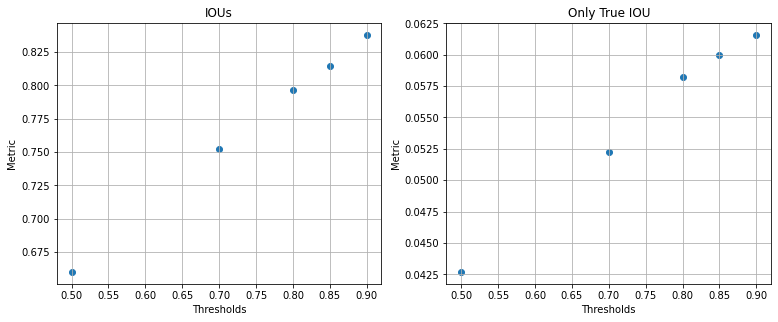

In [46]:
plt.figure(figsize=[6.4 * 2, 4.8])
plt.subplot(121)
plot_ious(f"IOUs", thresholds, ious)
plt.subplot(122)
plot_ious(f"Only True IOU", thresholds, true_ious)
plt.show()

In [47]:
# Load input and ground truth
for i_img in range(100):
  x_sample = x_test[i_img]
  y_ground_truth = y_test[i_img]

  x_sample_input = np.expand_dims(x_sample, 0)
  prediction = loaded_model.predict(x_sample_input)
  threshold = 0.9
  predicted_mask = np.where(prediction > threshold, 1, 0)[0]

  # Channel Correction
  if CHANNEL_CORRECTION:
    predicted_mask[:,:,[8, 12]] = predicted_mask[:,:,[12, 8]]
    predicted_mask[:,:,[13, 15]] = predicted_mask[:,:,[15, 13]]
    predicted_mask[:,:,[9, 10]] = predicted_mask[:,:,[10, 9]]
    predicted_mask[:,:,[6, 7]] = predicted_mask[:,:,[7, 6]]

  plot_labels = np.append(categories_names, 'background') if ADD_BACKGROUND else categories_names
  # plot_labeled_masks(x_sample, y_ground_truth, predicted_mask, plot_labels)
  plot_labeled_results(x_sample, y_ground_truth, predicted_mask, plot_labels)

  y_ground_truth_iou = np.expand_dims(y_ground_truth, 0)
  predicted_mask_iou = np.expand_dims(predicted_mask, 0)

  print(f"Total IoU score is {iou_score(y_ground_truth_iou, predicted_mask_iou, ADD_BACKGROUND)}")
  print(f"IoU score only for ground truth with objects in it is {only_true_iou_score(y_ground_truth_iou, predicted_mask_iou, ADD_BACKGROUND)}")

Output hidden; open in https://colab.research.google.com to view.